In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
import gc
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer
import pickle

gc.enable()

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

In [2]:
path = 'I:/Kaggle/jane-street-real-time-market-data-forecasting/'

In [3]:
first_items_list = os.listdir(path)

In [4]:
first_items_list

['features.csv',
 'kaggle_evaluation',
 'lags.parquet',
 'my_folder',
 'responders.csv',
 'sample_submission.csv',
 'test.parquet',
 'train.parquet']

In [5]:
# https://www.kaggle.com/code/yuanzhezhou/jane-street-baseline-lgb-xgb-and-catboost

def reduce_mem_usage(df, float16_as32=True):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)!='category':
            c_min,c_max = df[col].min(),df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    if float16_as32:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float16) 
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df.copy()

In [6]:
def read_parquet_files(train_or_test='train'):
    pq_folders_path = path + f"{train_or_test}.parquet/"
    folders_list = os.listdir(pq_folders_path)

    pq_list = []
    
    for folder in tqdm(folders_list):
        files_path = pq_folders_path + '/' + folder
        files_list = os.listdir(files_path)
        for file in files_list:
            if '.parquet' in file:
                pq_df = pd.read_parquet(files_path + '/' + file)

                if train_or_test == 'train':
                    cols_to_drop = [col for col in pq_df.columns if 'responder' in col]
                    cols_to_drop.remove('responder_6')
                    pq_df = pq_df.drop(cols_to_drop, axis=1)
                
                pq_list.append(pq_df)

    return reduce_mem_usage(pd.concat(pq_list, ignore_index=True), False)

In [7]:
train_scan = pl.scan_parquet(path + 'train.parquet/')
test_scan = pl.scan_parquet(path + 'test.parquet/')

In [8]:
train_symbol_ids_list = sorted(train_scan.select('symbol_id').unique().collect()['symbol_id'].to_list())
print(len(train_symbol_ids_list))
train_symbol_ids_list

39


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [9]:
test_symbol_ids_list = sorted(test_scan.select('symbol_id').unique().collect()['symbol_id'].to_list())
print(len(test_symbol_ids_list))
test_symbol_ids_list

39


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [10]:
unique_symbol_ids_list = sorted(list(set(train_symbol_ids_list + test_symbol_ids_list)))
print(len(unique_symbol_ids_list))
unique_symbol_ids_list

39


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [11]:
train_df = read_parquet_files()
y_sr = train_df['responder_6']
symbol_id_sr = train_df['symbol_id']
train_df = train_df.drop('responder_6', axis=1)
print(train_df.shape)
train_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


Memory usage of dataframe is 14427.07 MB
Memory usage after optimization is: 7415.78 MB
Decreased by 48.6%
(47127338, 83)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,1,3.888672,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494
1,0,0,7,1.371094,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490
2,0,0,9,2.285156,NaN,NaN,NaN,NaN,NaN,1.056641,0.187256,0.249878,-0.772949,11,7,76,-0.675781,-0.199463,-0.586914,NaN,-0.814941,NaN,-1.296875,-2.041016,0.639648,NaN,1.597656,0.657715,-1.350586,0.364258,NaN,NaN,-0.017746,-0.317383,-0.122375,NaN,NaN,NaN,-0.320801,-0.958008,-2.437500,0.070984,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420898,-3.515625,-4.679688,NaN,0.536133,NaN,NaN,-0.725586,NaN,-2.294922,1.764648,NaN,-0.120789,-0.063477,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.882812,-0.072510,-0.618164,-0.863281,-0.241943,-0.709961,NaN,NaN,0.377197,0.300781,-0.106812,-0.096802
3,0,0,10,0.690430,NaN,NaN,NaN,NaN,NaN,1.139648,0.273438,0.306641,-1.262695,42,5,150,-0.693848,3.003906,0.114807,NaN,-0.251953,NaN,-1.902344,-0.979492,0.241211,NaN,-0.392334,-0.224731,-2.128906,-0.855469,NaN,NaN,0.404053,-0.578125,0.105713,NaN,NaN,NaN,0.543945,-0.087097,-1.500000,-0.201294,-0.038055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382080,2.669922,0.611816,NaN,2.414062,NaN,NaN,1.313477,NaN,-0.810059,2.939453,NaN,3.988281,1.834961,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.697754,1.074219,-0.206909,-0.530762,4.765625,0.571777,NaN,NaN,-0.226929,-0.251465,-0.215576,-0.296143
4,0,0,14,0.440674,NaN,NaN,NaN,NaN,NaN,0.955078,0.262451,0.344482,-0.613770,44,3,16,-0.947266,-0.030014,-0.502441,NaN,0.645996,NaN,-1.844727,-1.586914,-0.182007,NaN,-0.969727,-0.673828,-1.282227,-1.399414,NaN,NaN,0.043823,-0.320312,-0.031708,NaN,NaN,NaN,-0.088440,-0.995117,-2.634766,-0.196411,-0.618652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.013672,-2.320312,-3.710938,NaN,1.253906,NaN,NaN,0.476074,NaN,-0.771973,2.843750,NaN,1.379883,0.411865,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.948730,-0.136841,-0.447754,-1.141602,0.099609,-0.662109,NaN,NaN,3.677734,2.792969,2.619141,3.417969


In [12]:
train_df.info(memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47127338 entries, 0 to 47127337
Data columns (total 83 columns):
 #   Column      Non-Null Count     Dtype  
---  ------      --------------     -----  
 0   date_id     47127338 non-null  int16  
 1   time_id     47127338 non-null  int16  
 2   symbol_id   47127338 non-null  int8   
 3   weight      47127338 non-null  float16
 4   feature_00  43945286 non-null  float16
 5   feature_01  43945286 non-null  float16
 6   feature_02  43945286 non-null  float16
 7   feature_03  43945286 non-null  float16
 8   feature_04  43945286 non-null  float16
 9   feature_05  47127338 non-null  float16
 10  feature_06  47127338 non-null  float16
 11  feature_07  47127338 non-null  float16
 12  feature_08  46827091 non-null  float16
 13  feature_09  47127338 non-null  int8   
 14  feature_10  47127338 non-null  int8   
 15  feature_11  47127338 non-null  int16  
 16  feature_12  47127338 non-null  float16
 17  feature_13  47127338 non-null  float16
 18  

In [13]:
test_df = read_parquet_files(train_or_test='test')
test_row_id_sr = test_df['row_id']
test_df = test_df.drop(['row_id', 'is_scored'], axis=1)
print(test_df.shape)
test_df

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.76it/s]

Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by 25.8%
(39, 83)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,0,3.169922,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
1,0,0,1,2.166016,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,0,0,2,3.066406,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
3,0,0,3,2.699219,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
4,0,0,4,1.803711,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
5,0,0,5,2.605469,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
6,0,0,6,1.047852,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
7,0,0,7,4.230469,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
8,0,0,8,2.599609,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,

In [14]:
test_df.info(memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 83 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_id     39 non-null     int8   
 1   time_id     39 non-null     int8   
 2   symbol_id   39 non-null     int8   
 3   weight      39 non-null     float16
 4   feature_00  39 non-null     float16
 5   feature_01  39 non-null     float16
 6   feature_02  39 non-null     float16
 7   feature_03  39 non-null     float16
 8   feature_04  39 non-null     float16
 9   feature_05  39 non-null     float16
 10  feature_06  39 non-null     float16
 11  feature_07  39 non-null     float16
 12  feature_08  39 non-null     float16
 13  feature_09  39 non-null     float16
 14  feature_10  39 non-null     float16
 15  feature_11  39 non-null     float16
 16  feature_12  39 non-null     float16
 17  feature_13  39 non-null     float16
 18  feature_14  39 non-null     float16
 19  feature_15  0 non-null      flo

In [15]:
lags_df = read_parquet_files(train_or_test='lags')
print(lags_df.shape)
lags_df

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.04it/s]

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 45.1%
(39, 12)


,date_id,time_id,symbol_id,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
0,0,0,0,-0.442139,-0.322510,0.143555,-0.926758,-0.782227,-0.036591,-1.305664,-0.795898,-0.143677
1,0,0,1,-0.651855,-1.708008,-0.894043,-1.065430,-1.871094,-0.615723,-1.163086,-1.206055,-1.246094
2,0,0,2,-0.656250,-0.264648,-0.893066,-1.511719,-1.033203,-0.378174,-1.574219,-1.863281,-0.027344
3,0,0,3,-0.188232,-0.190918,-0.701660,0.098450,-1.015625,-0.054993,0.329102,-0.965332,0.576660
4,0,0,4,-0.257568,-0.471436,-0.297363,0.074036,-0.324219,-0.597168,0.219849,-0.276367,-0.904785
5,0,0,5,0.027573,-0.020172,0.640137,-0.948242,-0.374268,-0.240356,-0.913574,-0.548828,-1.284180
6,0,0,6,-0.419678,-0.181274,-0.194092,0.667969,0.937012,0.517578,0.896484,1.069336,1.579102
7,0,0,7,-0.114136,-0.198486,-0.200073,-0.409912,-0.135132,-0.182861,-0.492188,-0.142944,-0.202026
8,0,0,8,-0.374268,0.092102,0.294678,0.403076,2.060547,-0.225098,0.956543,2.185547,-0.435791
9,0,0,9,-0.529297,0.040100,-0.333008,-0.958984,-1.318359,-0.774414,-0.716309,-1.471680,-1.107422


In [16]:
sample_df = pd.read_csv(path + 'sample_submission.csv')
print(sample_df.shape)
sample_df

(39, 2)


,row_id,responder_6
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
5,5,0.0
6,6,0.0
7,7,0.0
8,8,0.0
9,9,0.0


In [17]:
def one_hot_cat_cols(df):
    for v in tqdm(unique_symbol_ids_list):
        new_col_name = 'symbol_id_' + str(v)
        df[new_col_name] = (df['symbol_id'] == v).astype(int)
    
    #df = df.drop('symbol_id', axis=1)

    return df

In [18]:
train_df = one_hot_cat_cols(train_df)
print(train_df.shape)
train_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.04it/s]

(47127338, 122)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
0,0,0,1,3.888672,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,7,1.371094,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,9,2.285156,NaN,NaN,NaN,NaN,NaN,1.056641,0.187256,0.249878,-0.772949,11,7,76,-0.675781,-0.199463,-0.586914,NaN,-0.814941,NaN,-1.296875,-2.041016,0.639648,NaN,1.597656,0.657715,-1.350586,0.364258,NaN,NaN,-0.017746,-0.317383,-0.122375,NaN,NaN,NaN,-0.320801,-0.958008,-2.437500,0.070984,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420898,-3.515625,-4.679688,NaN,0.536133,NaN,NaN,-0.725586,NaN,-2.294922,1.764648,NaN,-0.120789,-0.063477,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.882812,-0.072510,-0.618164,-0.863281,-0.241943,-0.709961,NaN,NaN,0.377197,0.300781,-0.106812,-0.096802,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,10,0.690430,NaN,NaN,NaN,NaN,NaN,1.139648,0.273438,0.306641,-1.262695,42,5,150,-0.693848,3.003906,0.114807,NaN,-0.251953,NaN,-1.902344,-0.979492,0.241211,NaN,-0.392334,-0.224731,-2.128906,-0.855469,NaN,NaN,0.404053,-0.578125,0.105713,NaN,NaN,NaN,0.543945,-0.087097,-1.500000,-0.201294,-0.038055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382080,2.669922,0.611816,NaN,2.414062,NaN,NaN,1.313477,NaN,-0.810059,2.939453,NaN,3.988281,1.834961,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.697754,1.074219,-0.206909,-0.530762,4.765625,0.571777,NaN,NaN,-0.226929,-0.251465,-0.215576,-0.296143,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [19]:
test_df = one_hot_cat_cols(test_df)
print(test_df.shape)
test_df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 3477.64it/s]

(39, 122)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
0,0,0,0,3.169922,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,2.166016,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,2,3.066406,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,3,2.699219,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,4,1.803711,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
n_splits = 5

In [21]:
def xgb_train(train_data, y, idx_col):
    #X = train_data.drop(['weight', 'responder_6', 'row_id', 'is_scored'], axis=1)
    X = train_data.drop(['weight'], axis=1)
    #y = y.copy()
    weights = train_data['weight']
     
    oof = np.zeros(len(y), dtype=float)

    models_list = []

    base_params = {
        #'random_state': SEED,
        #'tree_method': 'gpu_hist',
        'device': 'cuda',
        'n_estimators': 1000,
        'early_stopping_rounds': 30,
        'learning_rate': 0.7
        #'booster': 'gblinear'
        #'verbosity': 0
    }

    fold_0_model = XGBRegressor(
        **base_params
    )

    fold_1_model = XGBRegressor(
        **base_params
    )

    fold_2_model = XGBRegressor(
        **base_params
    )

    fold_3_model = XGBRegressor(
        **base_params
    )

    fold_4_model = XGBRegressor(
        **base_params
    )

    

    first_level_cv_fold = KFold(n_splits=5, shuffle=True)#, shuffle=True, random_state=6)

    #for first_level_fold, (train_idx, test_idx) in enumerate(first_level_cv_fold.split(X, train_data['date_id'])):
    for first_level_fold, (train_idx, test_idx) in enumerate(first_level_cv_fold.split(X)):
        X_val = X.iloc[test_idx]
        y_val = y.iloc[test_idx]
        weights_val = weights.iloc[test_idx]

        print(X_val.shape)

        second_level_cv_fold = KFold(n_splits=5, shuffle=True)

        #for second_level_fold, (train_idx2, test_idx2) in enumerate(second_level_cv_fold.split(X_val, X_val['date_id'])):
        for second_level_fold, (train_idx2, test_idx2) in enumerate(second_level_cv_fold.split(X_val)):
            X_train2, X_val2 = X_val.iloc[train_idx2].drop(['symbol_id'], axis=1), X_val.iloc[test_idx2].drop(['symbol_id'], axis=1)
            y_train2, y_val2 = y_val.iloc[train_idx2], y_val.iloc[test_idx2]
            weights_train2, weights_val2 = weights_val.iloc[train_idx2], weights_val.iloc[test_idx2]

            if second_level_fold == 0:
                
                fold_0_model.fit(X_train2, y_train2, sample_weight=weights_train2, eval_set=[(X_train2, y_train2), (X_val2, y_val2)], sample_weight_eval_set=[weights_train2, weights_val2], verbose=10)

                oof[test_idx2] = fold_0_model.predict(X_val2)

                
                plt.figure(figsize=(10, 6))

                eval_results = fold_0_model.evals_result_
        
                # Extract metrics
                train_rmse = eval_results['validation_0']['rmse']
                val_rmse = eval_results['validation_1']['rmse']
                plt.plot(train_rmse, label='Training RMSE')
                plt.plot(val_rmse, label='Validation RMSE')
                plt.ylabel('RMSE')
                plt.title('Training vs Validation RMSE')
                
                # Plot the results
                plt.xlabel('Boosting Rounds')
                plt.legend()
                plt.grid(True)
                plt.show()

            elif second_level_fold == 1:
                
                fold_1_model.fit(X_train2, y_train2, sample_weight=weights_train2, eval_set=[(X_train2, y_train2), (X_val2, y_val2)], sample_weight_eval_set=[weights_train2, weights_val2], verbose=10)

                oof[test_idx2] = fold_1_model.predict(X_val2)


                plt.figure(figsize=(10, 6))

                eval_results = fold_1_model.evals_result_
        
                # Extract metrics
                train_rmse = eval_results['validation_0']['rmse']
                val_rmse = eval_results['validation_1']['rmse']
                plt.plot(train_rmse, label='Training RMSE')
                plt.plot(val_rmse, label='Validation RMSE')
                plt.ylabel('RMSE')
                plt.title('Training vs Validation RMSE')
                
                # Plot the results
                plt.xlabel('Boosting Rounds')
                plt.legend()
                plt.grid(True)
                plt.show()
            

            elif second_level_fold == 2:
                
                fold_2_model.fit(X_train2, y_train2, sample_weight=weights_train2, eval_set=[(X_train2, y_train2), (X_val2, y_val2)], sample_weight_eval_set=[weights_train2, weights_val2], verbose=10)

                oof[test_idx2] = fold_2_model.predict(X_val2)


                plt.figure(figsize=(10, 6))

                eval_results = fold_2_model.evals_result_
        
                # Extract metrics
                train_rmse = eval_results['validation_0']['rmse']
                val_rmse = eval_results['validation_1']['rmse']
                plt.plot(train_rmse, label='Training RMSE')
                plt.plot(val_rmse, label='Validation RMSE')
                plt.ylabel('RMSE')
                plt.title('Training vs Validation RMSE')
                
                # Plot the results
                plt.xlabel('Boosting Rounds')
                plt.legend()
                plt.grid(True)
                plt.show()

            elif second_level_fold == 3:
                
                fold_3_model.fit(X_train2, y_train2, sample_weight=weights_train2, eval_set=[(X_train2, y_train2), (X_val2, y_val2)], sample_weight_eval_set=[weights_train2, weights_val2], verbose=10)

                oof[test_idx2] = fold_3_model.predict(X_val2)


                plt.figure(figsize=(10, 6))

                eval_results = fold_3_model.evals_result_
        
                # Extract metrics
                train_rmse = eval_results['validation_0']['rmse']
                val_rmse = eval_results['validation_1']['rmse']
                plt.plot(train_rmse, label='Training RMSE')
                plt.plot(val_rmse, label='Validation RMSE')
                plt.ylabel('RMSE')
                plt.title('Training vs Validation RMSE')
                
                # Plot the results
                plt.xlabel('Boosting Rounds')
                plt.legend()
                plt.grid(True)
                plt.show()

            elif second_level_fold == 4:
                
                fold_4_model.fit(X_train2, y_train2, sample_weight=weights_train2, eval_set=[(X_train2, y_train2), (X_val2, y_val2)], sample_weight_eval_set=[weights_train2, weights_val2], verbose=10)

                oof[test_idx2] = fold_4_model.predict(X_val2)


                plt.figure(figsize=(10, 6))

                eval_results = fold_4_model.evals_result_
        
                # Extract metrics
                train_rmse = eval_results['validation_0']['rmse']
                val_rmse = eval_results['validation_1']['rmse']
                plt.plot(train_rmse, label='Training RMSE')
                plt.plot(val_rmse, label='Validation RMSE')
                plt.ylabel('RMSE')
                plt.title('Training vs Validation RMSE')
                
                # Plot the results
                plt.xlabel('Boosting Rounds')
                plt.legend()
                plt.grid(True)
                plt.show()

            

        

        '''model = XGBRegressor(
            **base_params
        )

        #model.fit(train_dmatrix, eval_set=val_dmatrix, verbose=10)
        
        model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], sample_weight_eval_set=[weights_train, weights_val], verbose=10)
        
        oof[test_idx] = model.predict(X_val)

        plt.figure(figsize=(10, 6))

        eval_results = model.evals_result_

        # Extract metrics
        train_rmse = eval_results['validation_0']['rmse']
        val_rmse = eval_results['validation_1']['rmse']
        plt.plot(train_rmse, label='Training RMSE')
        plt.plot(val_rmse, label='Validation RMSE')
        plt.ylabel('RMSE')
        plt.title('Training vs Validation RMSE')
        
        # Plot the results
        plt.xlabel('Boosting Rounds')
        plt.legend()
        plt.grid(True)
        plt.show()

        #print(model.score(X_val, y_val, sample_weight=weights_val))'''

    print('R2 score is:', r2_score(y, oof, sample_weight=weights))

    models_path = path + 'my_folder/models/20241223_01/'

    if not os.path.exists(models_path):
        os.makedirs(models_path)
        

    with open(models_path + 'xgb_model_0.pkl', 'wb') as file:
        pickle.dump(fold_0_model, file)

    with open(models_path + 'xgb_model_1.pkl', 'wb') as file:
        pickle.dump(fold_1_model, file)

    with open(models_path + 'xgb_model_2.pkl', 'wb') as file:
        pickle.dump(fold_2_model, file)

    with open(models_path + 'xgb_model_3.pkl', 'wb') as file:
        pickle.dump(fold_3_model, file)

    with open(models_path + 'xgb_model_4.pkl', 'wb') as file:
        pickle.dump(fold_4_model, file)

    return

(9425468, 121)
[0]	validation_0-rmse:0.84756	validation_1-rmse:0.84675
[10]	validation_0-rmse:0.84153	validation_1-rmse:0.84262
[20]	validation_0-rmse:0.83801	validation_1-rmse:0.84075
[30]	validation_0-rmse:0.83493	validation_1-rmse:0.83942
[40]	validation_0-rmse:0.83243	validation_1-rmse:0.83833
[50]	validation_0-rmse:0.82996	validation_1-rmse:0.83725
[60]	validation_0-rmse:0.82808	validation_1-rmse:0.83674
[70]	validation_0-rmse:0.82597	validation_1-rmse:0.83597
[80]	validation_0-rmse:0.82423	validation_1-rmse:0.83549
[90]	validation_0-rmse:0.82219	validation_1-rmse:0.83480
[100]	validation_0-rmse:0.82061	validation_1-rmse:0.83435
[110]	validation_0-rmse:0.81886	validation_1-rmse:0.83413
[120]	validation_0-rmse:0.81732	validation_1-rmse:0.83365
[130]	validation_0-rmse:0.81581	validation_1-rmse:0.83326
[140]	validation_0-rmse:0.81436	validation_1-rmse:0.83283
[150]	validation_0-rmse:0.81282	validation_1-rmse:0.83234
[160]	validation_0-rmse:0.81140	validation_1-rmse:0.83192
[170]	vali

I:\Kaggle\kaggle_venvs\ml\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


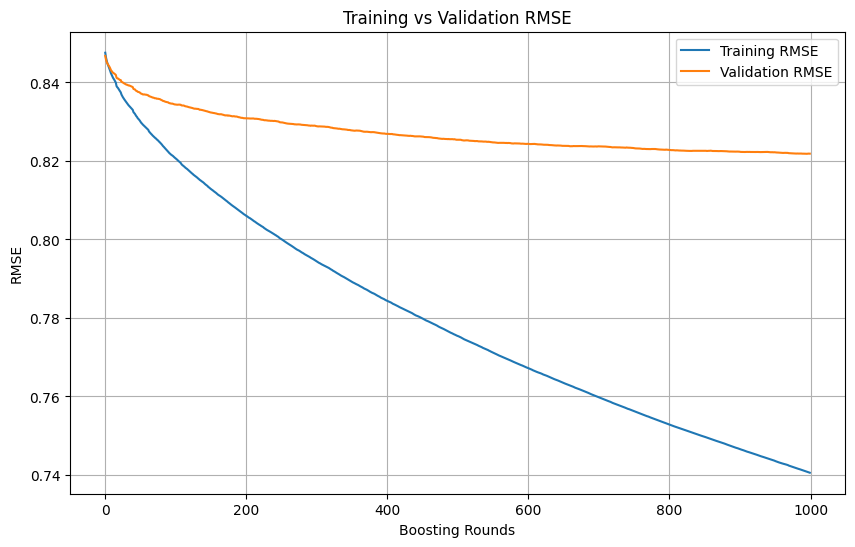

[0]	validation_0-rmse:0.84688	validation_1-rmse:0.84954
[10]	validation_0-rmse:0.84075	validation_1-rmse:0.84512
[20]	validation_0-rmse:0.83671	validation_1-rmse:0.84284
[30]	validation_0-rmse:0.83350	validation_1-rmse:0.84143
[40]	validation_0-rmse:0.83076	validation_1-rmse:0.83996
[50]	validation_0-rmse:0.82870	validation_1-rmse:0.83944
[60]	validation_0-rmse:0.82673	validation_1-rmse:0.83890
[70]	validation_0-rmse:0.82477	validation_1-rmse:0.83831
[80]	validation_0-rmse:0.82297	validation_1-rmse:0.83778
[90]	validation_0-rmse:0.82122	validation_1-rmse:0.83734
[100]	validation_0-rmse:0.81939	validation_1-rmse:0.83684
[110]	validation_0-rmse:0.81781	validation_1-rmse:0.83648
[120]	validation_0-rmse:0.81625	validation_1-rmse:0.83589
[130]	validation_0-rmse:0.81486	validation_1-rmse:0.83549
[140]	validation_0-rmse:0.81334	validation_1-rmse:0.83502
[150]	validation_0-rmse:0.81206	validation_1-rmse:0.83483
[160]	validation_0-rmse:0.81053	validation_1-rmse:0.83456
[170]	validation_0-rmse:0

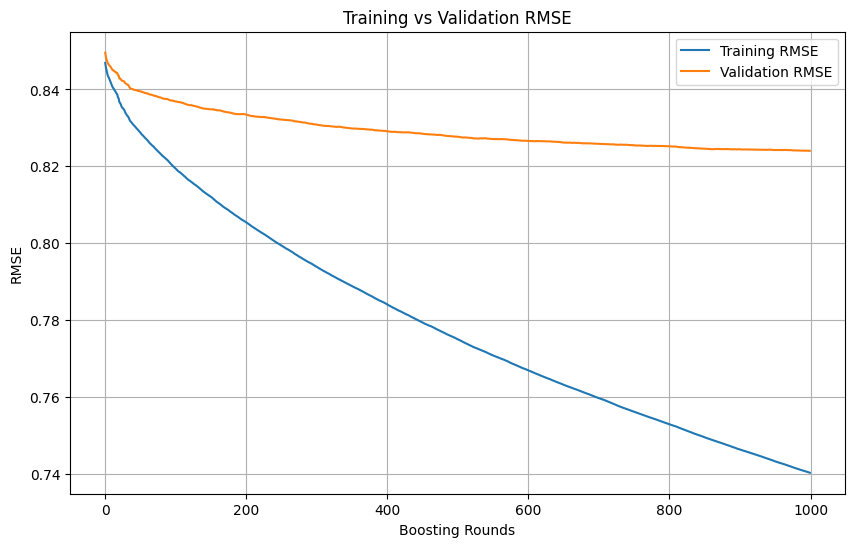

[0]	validation_0-rmse:0.84765	validation_1-rmse:0.84657
[10]	validation_0-rmse:0.84165	validation_1-rmse:0.84243
[20]	validation_0-rmse:0.83760	validation_1-rmse:0.84015
[30]	validation_0-rmse:0.83444	validation_1-rmse:0.83881
[40]	validation_0-rmse:0.83176	validation_1-rmse:0.83758
[50]	validation_0-rmse:0.82938	validation_1-rmse:0.83663
[60]	validation_0-rmse:0.82733	validation_1-rmse:0.83586
[70]	validation_0-rmse:0.82540	validation_1-rmse:0.83517
[80]	validation_0-rmse:0.82371	validation_1-rmse:0.83475
[90]	validation_0-rmse:0.82184	validation_1-rmse:0.83427
[100]	validation_0-rmse:0.81995	validation_1-rmse:0.83364
[110]	validation_0-rmse:0.81837	validation_1-rmse:0.83315
[120]	validation_0-rmse:0.81682	validation_1-rmse:0.83266
[130]	validation_0-rmse:0.81536	validation_1-rmse:0.83241
[140]	validation_0-rmse:0.81386	validation_1-rmse:0.83200
[150]	validation_0-rmse:0.81240	validation_1-rmse:0.83161
[160]	validation_0-rmse:0.81082	validation_1-rmse:0.83117
[170]	validation_0-rmse:0

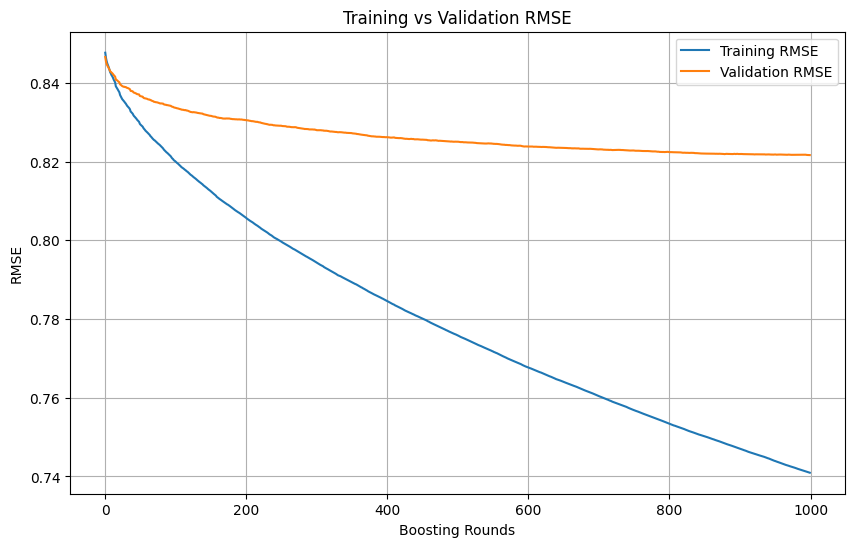

[0]	validation_0-rmse:0.84709	validation_1-rmse:0.84833
[10]	validation_0-rmse:0.84127	validation_1-rmse:0.84436
[20]	validation_0-rmse:0.83665	validation_1-rmse:0.84164
[30]	validation_0-rmse:0.83390	validation_1-rmse:0.84048
[40]	validation_0-rmse:0.83135	validation_1-rmse:0.83962
[50]	validation_0-rmse:0.82927	validation_1-rmse:0.83898
[60]	validation_0-rmse:0.82710	validation_1-rmse:0.83816
[70]	validation_0-rmse:0.82522	validation_1-rmse:0.83770
[80]	validation_0-rmse:0.82364	validation_1-rmse:0.83721
[90]	validation_0-rmse:0.82193	validation_1-rmse:0.83669
[100]	validation_0-rmse:0.82020	validation_1-rmse:0.83611
[110]	validation_0-rmse:0.81852	validation_1-rmse:0.83557
[120]	validation_0-rmse:0.81694	validation_1-rmse:0.83521
[130]	validation_0-rmse:0.81549	validation_1-rmse:0.83489
[140]	validation_0-rmse:0.81408	validation_1-rmse:0.83454
[150]	validation_0-rmse:0.81248	validation_1-rmse:0.83408
[160]	validation_0-rmse:0.81104	validation_1-rmse:0.83369
[170]	validation_0-rmse:0

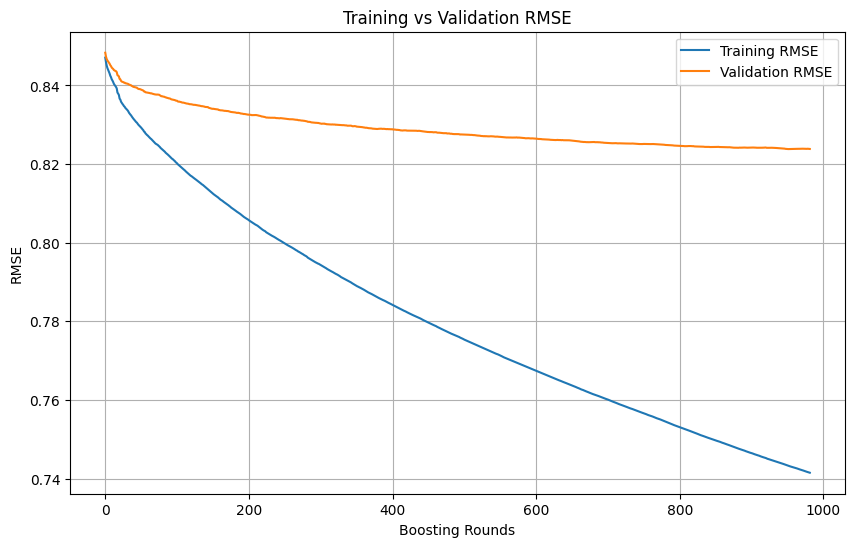

[0]	validation_0-rmse:0.84767	validation_1-rmse:0.84698
[10]	validation_0-rmse:0.84112	validation_1-rmse:0.84269
[20]	validation_0-rmse:0.83778	validation_1-rmse:0.84104
[30]	validation_0-rmse:0.83499	validation_1-rmse:0.84021
[40]	validation_0-rmse:0.83252	validation_1-rmse:0.83929
[50]	validation_0-rmse:0.83048	validation_1-rmse:0.83854
[60]	validation_0-rmse:0.82824	validation_1-rmse:0.83767
[70]	validation_0-rmse:0.82640	validation_1-rmse:0.83713
[80]	validation_0-rmse:0.82441	validation_1-rmse:0.83667
[90]	validation_0-rmse:0.82267	validation_1-rmse:0.83615
[100]	validation_0-rmse:0.82108	validation_1-rmse:0.83573
[110]	validation_0-rmse:0.81935	validation_1-rmse:0.83512
[120]	validation_0-rmse:0.81753	validation_1-rmse:0.83456
[130]	validation_0-rmse:0.81605	validation_1-rmse:0.83424
[140]	validation_0-rmse:0.81439	validation_1-rmse:0.83371
[150]	validation_0-rmse:0.81298	validation_1-rmse:0.83355
[160]	validation_0-rmse:0.81147	validation_1-rmse:0.83316
[170]	validation_0-rmse:0

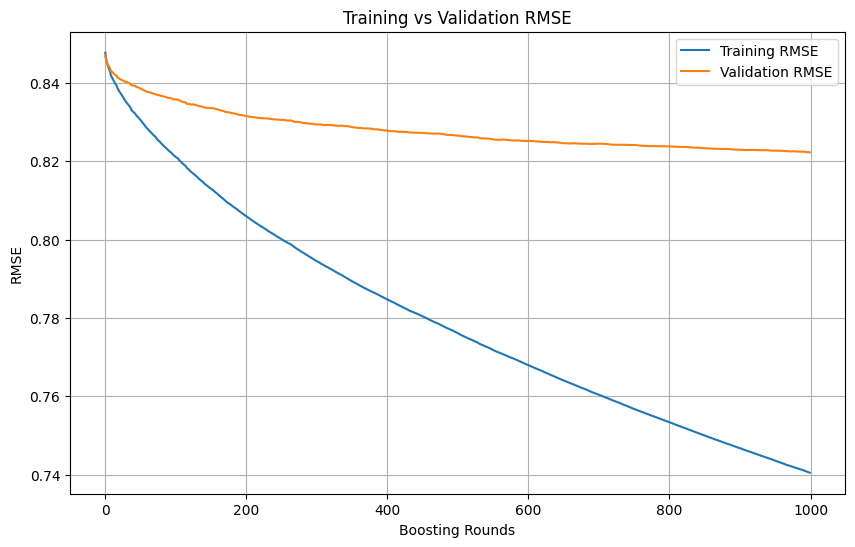

(9425468, 121)
[0]	validation_0-rmse:0.84731	validation_1-rmse:0.84822
[10]	validation_0-rmse:0.84114	validation_1-rmse:0.84399
[20]	validation_0-rmse:0.83731	validation_1-rmse:0.84192
[30]	validation_0-rmse:0.83462	validation_1-rmse:0.84089
[40]	validation_0-rmse:0.83206	validation_1-rmse:0.83988
[50]	validation_0-rmse:0.83004	validation_1-rmse:0.83935
[60]	validation_0-rmse:0.82740	validation_1-rmse:0.83826
[70]	validation_0-rmse:0.82563	validation_1-rmse:0.83778
[80]	validation_0-rmse:0.82363	validation_1-rmse:0.83728
[90]	validation_0-rmse:0.82180	validation_1-rmse:0.83665
[100]	validation_0-rmse:0.82000	validation_1-rmse:0.83622
[110]	validation_0-rmse:0.81832	validation_1-rmse:0.83577
[120]	validation_0-rmse:0.81689	validation_1-rmse:0.83571
[130]	validation_0-rmse:0.81545	validation_1-rmse:0.83539
[140]	validation_0-rmse:0.81379	validation_1-rmse:0.83479
[150]	validation_0-rmse:0.81233	validation_1-rmse:0.83447
[160]	validation_0-rmse:0.81092	validation_1-rmse:0.83407
[170]	vali

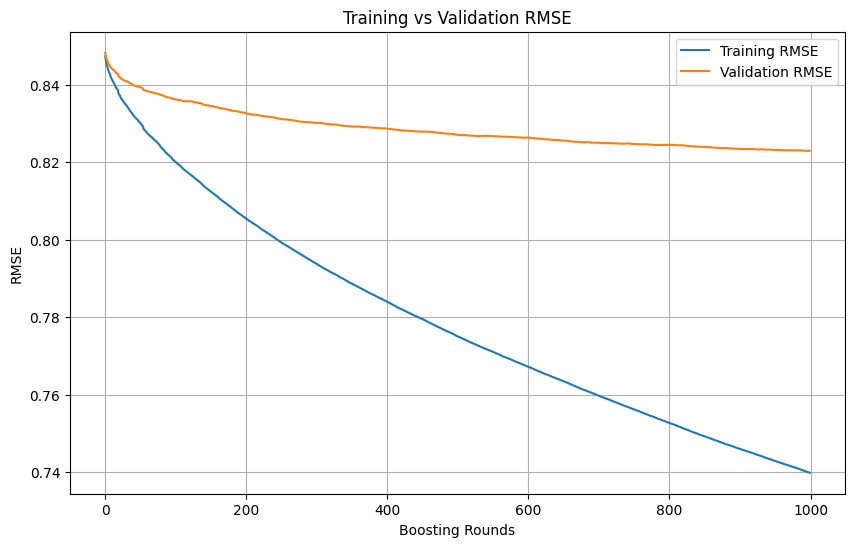

[0]	validation_0-rmse:0.84785	validation_1-rmse:0.84587
[10]	validation_0-rmse:0.84196	validation_1-rmse:0.84205
[20]	validation_0-rmse:0.83804	validation_1-rmse:0.84002
[30]	validation_0-rmse:0.83467	validation_1-rmse:0.83830
[40]	validation_0-rmse:0.83220	validation_1-rmse:0.83728
[50]	validation_0-rmse:0.83002	validation_1-rmse:0.83645
[60]	validation_0-rmse:0.82820	validation_1-rmse:0.83599
[70]	validation_0-rmse:0.82588	validation_1-rmse:0.83511
[80]	validation_0-rmse:0.82387	validation_1-rmse:0.83437
[90]	validation_0-rmse:0.82206	validation_1-rmse:0.83394
[100]	validation_0-rmse:0.82028	validation_1-rmse:0.83369
[110]	validation_0-rmse:0.81861	validation_1-rmse:0.83348
[120]	validation_0-rmse:0.81708	validation_1-rmse:0.83317
[130]	validation_0-rmse:0.81572	validation_1-rmse:0.83285
[140]	validation_0-rmse:0.81419	validation_1-rmse:0.83236
[150]	validation_0-rmse:0.81287	validation_1-rmse:0.83207
[160]	validation_0-rmse:0.81151	validation_1-rmse:0.83179
[170]	validation_0-rmse:0

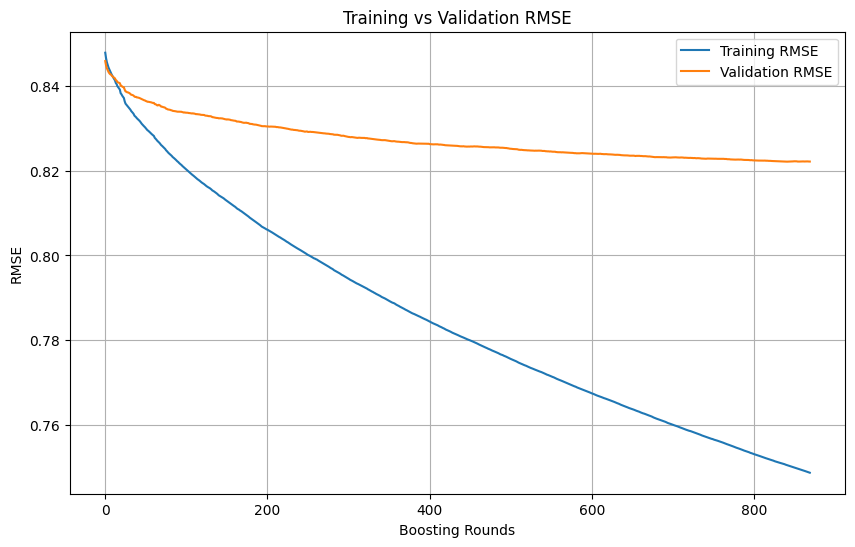

[0]	validation_0-rmse:0.84751	validation_1-rmse:0.84733
[10]	validation_0-rmse:0.84173	validation_1-rmse:0.84369
[20]	validation_0-rmse:0.83791	validation_1-rmse:0.84160
[30]	validation_0-rmse:0.83553	validation_1-rmse:0.84078
[40]	validation_0-rmse:0.83292	validation_1-rmse:0.83957
[50]	validation_0-rmse:0.83080	validation_1-rmse:0.83886
[60]	validation_0-rmse:0.82868	validation_1-rmse:0.83818
[70]	validation_0-rmse:0.82650	validation_1-rmse:0.83748
[80]	validation_0-rmse:0.82468	validation_1-rmse:0.83691
[90]	validation_0-rmse:0.82259	validation_1-rmse:0.83602
[100]	validation_0-rmse:0.82081	validation_1-rmse:0.83551
[110]	validation_0-rmse:0.81908	validation_1-rmse:0.83510
[120]	validation_0-rmse:0.81744	validation_1-rmse:0.83477
[130]	validation_0-rmse:0.81582	validation_1-rmse:0.83430
[140]	validation_0-rmse:0.81435	validation_1-rmse:0.83389
[150]	validation_0-rmse:0.81293	validation_1-rmse:0.83354
[160]	validation_0-rmse:0.81153	validation_1-rmse:0.83324
[170]	validation_0-rmse:0

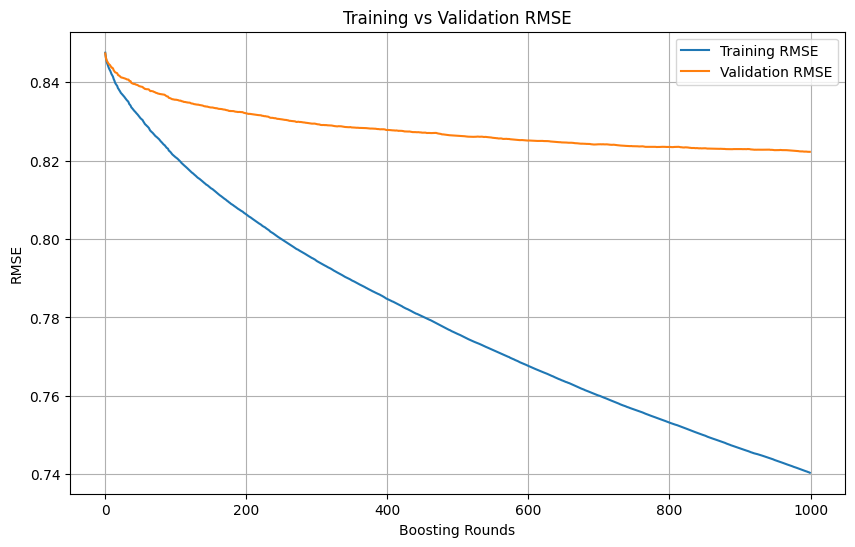

[0]	validation_0-rmse:0.84737	validation_1-rmse:0.84819
[10]	validation_0-rmse:0.84138	validation_1-rmse:0.84422
[20]	validation_0-rmse:0.83811	validation_1-rmse:0.84258
[30]	validation_0-rmse:0.83520	validation_1-rmse:0.84125
[40]	validation_0-rmse:0.83287	validation_1-rmse:0.84044
[50]	validation_0-rmse:0.83064	validation_1-rmse:0.83951
[60]	validation_0-rmse:0.82845	validation_1-rmse:0.83867
[70]	validation_0-rmse:0.82598	validation_1-rmse:0.83774
[80]	validation_0-rmse:0.82424	validation_1-rmse:0.83735
[90]	validation_0-rmse:0.82223	validation_1-rmse:0.83660
[100]	validation_0-rmse:0.82044	validation_1-rmse:0.83609
[110]	validation_0-rmse:0.81885	validation_1-rmse:0.83570
[120]	validation_0-rmse:0.81738	validation_1-rmse:0.83522
[130]	validation_0-rmse:0.81600	validation_1-rmse:0.83483
[140]	validation_0-rmse:0.81456	validation_1-rmse:0.83455
[150]	validation_0-rmse:0.81307	validation_1-rmse:0.83439
[160]	validation_0-rmse:0.81174	validation_1-rmse:0.83402
[170]	validation_0-rmse:0

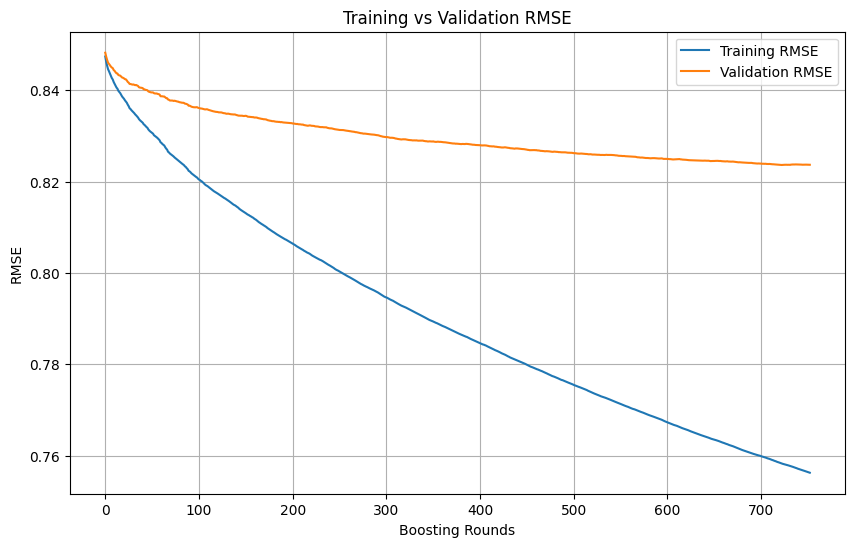

[0]	validation_0-rmse:0.84715	validation_1-rmse:0.84879
[10]	validation_0-rmse:0.84112	validation_1-rmse:0.84477
[20]	validation_0-rmse:0.83774	validation_1-rmse:0.84335
[30]	validation_0-rmse:0.83437	validation_1-rmse:0.84161
[40]	validation_0-rmse:0.83197	validation_1-rmse:0.84104
[50]	validation_0-rmse:0.82956	validation_1-rmse:0.84015
[60]	validation_0-rmse:0.82748	validation_1-rmse:0.83972
[70]	validation_0-rmse:0.82527	validation_1-rmse:0.83883
[80]	validation_0-rmse:0.82335	validation_1-rmse:0.83830
[90]	validation_0-rmse:0.82176	validation_1-rmse:0.83795
[100]	validation_0-rmse:0.82013	validation_1-rmse:0.83770
[110]	validation_0-rmse:0.81849	validation_1-rmse:0.83725
[120]	validation_0-rmse:0.81685	validation_1-rmse:0.83684
[130]	validation_0-rmse:0.81525	validation_1-rmse:0.83643
[140]	validation_0-rmse:0.81381	validation_1-rmse:0.83616
[150]	validation_0-rmse:0.81233	validation_1-rmse:0.83590
[160]	validation_0-rmse:0.81095	validation_1-rmse:0.83550
[170]	validation_0-rmse:0

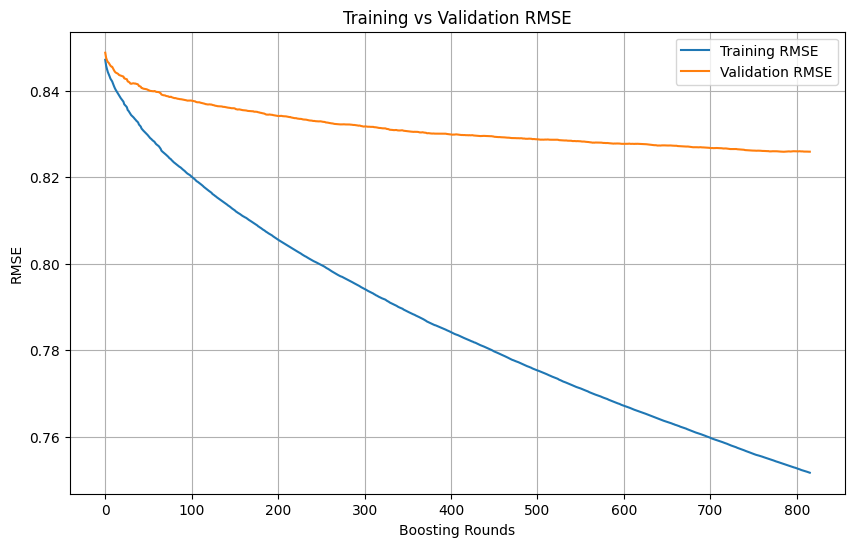

(9425468, 121)
[0]	validation_0-rmse:0.84669	validation_1-rmse:0.84718
[10]	validation_0-rmse:0.84020	validation_1-rmse:0.84285
[20]	validation_0-rmse:0.83656	validation_1-rmse:0.84090
[30]	validation_0-rmse:0.83409	validation_1-rmse:0.83988
[40]	validation_0-rmse:0.83137	validation_1-rmse:0.83875
[50]	validation_0-rmse:0.82906	validation_1-rmse:0.83781
[60]	validation_0-rmse:0.82703	validation_1-rmse:0.83714
[70]	validation_0-rmse:0.82519	validation_1-rmse:0.83661
[80]	validation_0-rmse:0.82311	validation_1-rmse:0.83576
[90]	validation_0-rmse:0.82124	validation_1-rmse:0.83540
[100]	validation_0-rmse:0.81972	validation_1-rmse:0.83515
[110]	validation_0-rmse:0.81802	validation_1-rmse:0.83475
[120]	validation_0-rmse:0.81627	validation_1-rmse:0.83436
[130]	validation_0-rmse:0.81461	validation_1-rmse:0.83379
[140]	validation_0-rmse:0.81317	validation_1-rmse:0.83344
[150]	validation_0-rmse:0.81165	validation_1-rmse:0.83291
[160]	validation_0-rmse:0.81034	validation_1-rmse:0.83271
[170]	vali

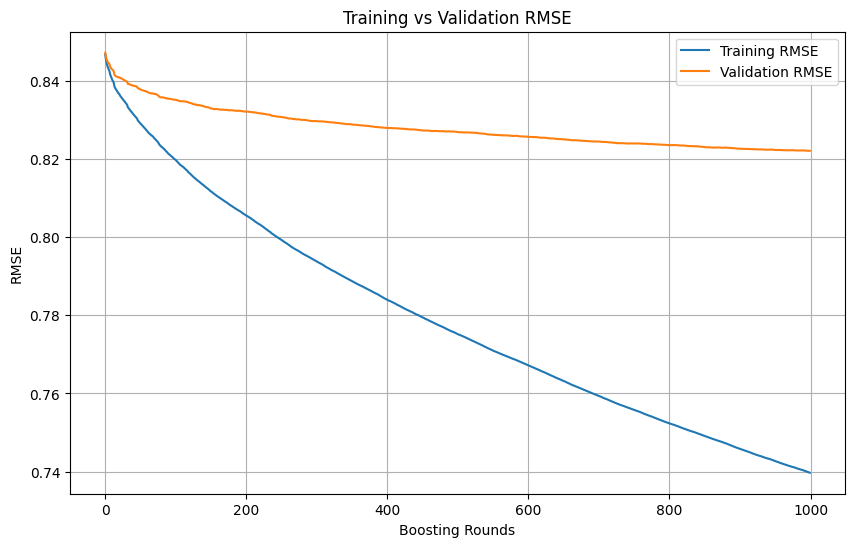

[0]	validation_0-rmse:0.84688	validation_1-rmse:0.84649
[10]	validation_0-rmse:0.84088	validation_1-rmse:0.84232
[20]	validation_0-rmse:0.83767	validation_1-rmse:0.84099
[30]	validation_0-rmse:0.83446	validation_1-rmse:0.83948
[40]	validation_0-rmse:0.83208	validation_1-rmse:0.83830
[50]	validation_0-rmse:0.83003	validation_1-rmse:0.83785
[60]	validation_0-rmse:0.82796	validation_1-rmse:0.83711
[70]	validation_0-rmse:0.82574	validation_1-rmse:0.83629
[80]	validation_0-rmse:0.82365	validation_1-rmse:0.83535
[90]	validation_0-rmse:0.82159	validation_1-rmse:0.83457
[100]	validation_0-rmse:0.82003	validation_1-rmse:0.83414
[110]	validation_0-rmse:0.81855	validation_1-rmse:0.83368
[120]	validation_0-rmse:0.81672	validation_1-rmse:0.83311
[130]	validation_0-rmse:0.81530	validation_1-rmse:0.83282
[140]	validation_0-rmse:0.81388	validation_1-rmse:0.83244
[150]	validation_0-rmse:0.81235	validation_1-rmse:0.83205
[160]	validation_0-rmse:0.81098	validation_1-rmse:0.83176
[170]	validation_0-rmse:0

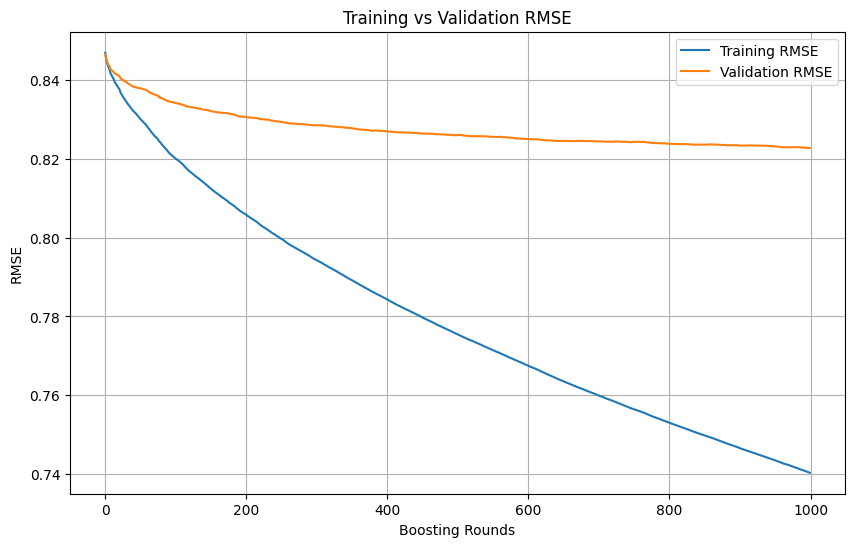

[0]	validation_0-rmse:0.84707	validation_1-rmse:0.84575
[10]	validation_0-rmse:0.84100	validation_1-rmse:0.84136
[20]	validation_0-rmse:0.83768	validation_1-rmse:0.83973
[30]	validation_0-rmse:0.83479	validation_1-rmse:0.83838
[40]	validation_0-rmse:0.83193	validation_1-rmse:0.83684
[50]	validation_0-rmse:0.82983	validation_1-rmse:0.83624
[60]	validation_0-rmse:0.82741	validation_1-rmse:0.83523
[70]	validation_0-rmse:0.82532	validation_1-rmse:0.83484
[80]	validation_0-rmse:0.82356	validation_1-rmse:0.83433
[90]	validation_0-rmse:0.82182	validation_1-rmse:0.83382
[100]	validation_0-rmse:0.81998	validation_1-rmse:0.83307
[110]	validation_0-rmse:0.81830	validation_1-rmse:0.83286
[120]	validation_0-rmse:0.81677	validation_1-rmse:0.83242
[130]	validation_0-rmse:0.81533	validation_1-rmse:0.83216
[140]	validation_0-rmse:0.81379	validation_1-rmse:0.83176
[150]	validation_0-rmse:0.81225	validation_1-rmse:0.83121
[160]	validation_0-rmse:0.81082	validation_1-rmse:0.83092
[170]	validation_0-rmse:0

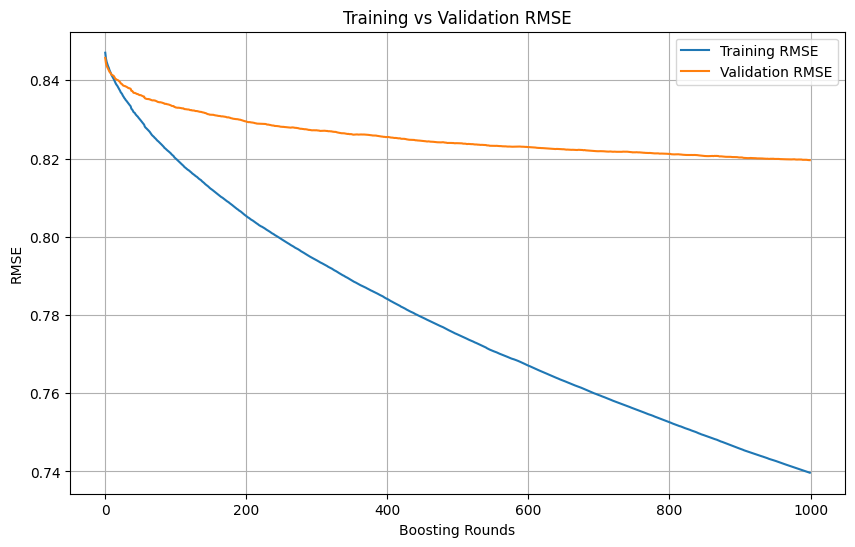

[0]	validation_0-rmse:0.84650	validation_1-rmse:0.84858
[10]	validation_0-rmse:0.84014	validation_1-rmse:0.84427
[20]	validation_0-rmse:0.83652	validation_1-rmse:0.84221
[30]	validation_0-rmse:0.83392	validation_1-rmse:0.84112
[40]	validation_0-rmse:0.83165	validation_1-rmse:0.84026
[50]	validation_0-rmse:0.82891	validation_1-rmse:0.83892
[60]	validation_0-rmse:0.82692	validation_1-rmse:0.83819
[70]	validation_0-rmse:0.82455	validation_1-rmse:0.83723
[80]	validation_0-rmse:0.82278	validation_1-rmse:0.83679
[90]	validation_0-rmse:0.82100	validation_1-rmse:0.83643
[100]	validation_0-rmse:0.81951	validation_1-rmse:0.83609
[110]	validation_0-rmse:0.81785	validation_1-rmse:0.83563
[120]	validation_0-rmse:0.81630	validation_1-rmse:0.83526
[130]	validation_0-rmse:0.81487	validation_1-rmse:0.83505
[140]	validation_0-rmse:0.81335	validation_1-rmse:0.83474
[150]	validation_0-rmse:0.81190	validation_1-rmse:0.83434
[160]	validation_0-rmse:0.81054	validation_1-rmse:0.83393
[170]	validation_0-rmse:0

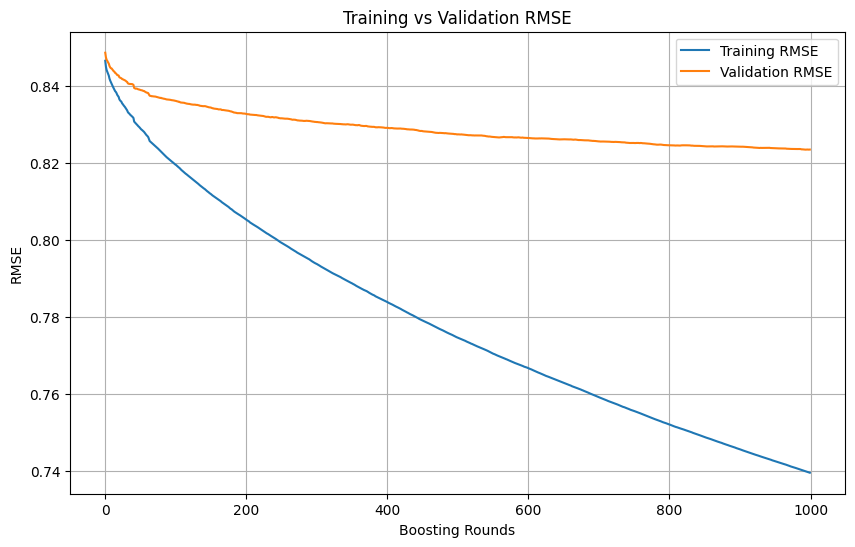

[0]	validation_0-rmse:0.84667	validation_1-rmse:0.84727
[10]	validation_0-rmse:0.84076	validation_1-rmse:0.84334
[20]	validation_0-rmse:0.83732	validation_1-rmse:0.84190
[30]	validation_0-rmse:0.83370	validation_1-rmse:0.83980
[40]	validation_0-rmse:0.83144	validation_1-rmse:0.83908
[50]	validation_0-rmse:0.82845	validation_1-rmse:0.83763
[60]	validation_0-rmse:0.82643	validation_1-rmse:0.83695
[70]	validation_0-rmse:0.82460	validation_1-rmse:0.83648
[80]	validation_0-rmse:0.82275	validation_1-rmse:0.83588
[90]	validation_0-rmse:0.82083	validation_1-rmse:0.83516
[100]	validation_0-rmse:0.81928	validation_1-rmse:0.83486
[110]	validation_0-rmse:0.81779	validation_1-rmse:0.83461
[120]	validation_0-rmse:0.81609	validation_1-rmse:0.83403
[130]	validation_0-rmse:0.81462	validation_1-rmse:0.83354
[140]	validation_0-rmse:0.81318	validation_1-rmse:0.83333
[150]	validation_0-rmse:0.81167	validation_1-rmse:0.83289
[160]	validation_0-rmse:0.81020	validation_1-rmse:0.83258
[170]	validation_0-rmse:0

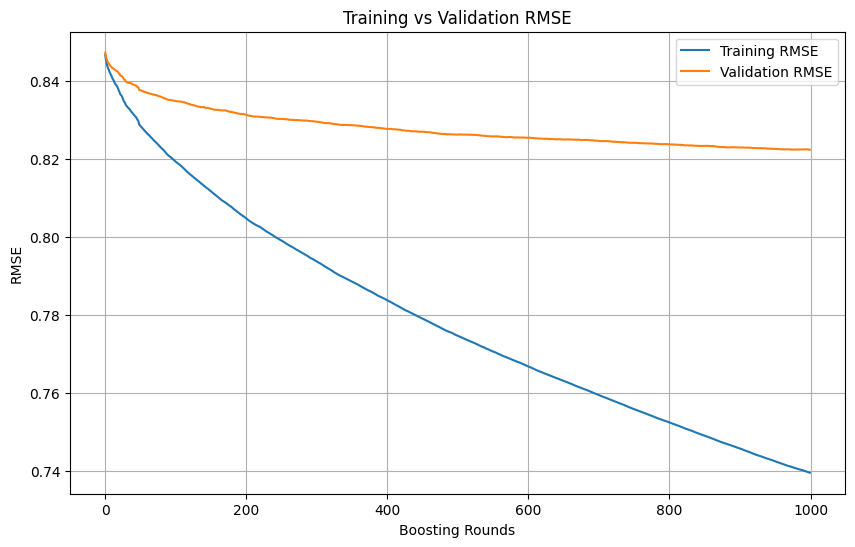

(9425467, 121)
[0]	validation_0-rmse:0.84692	validation_1-rmse:0.84489
[10]	validation_0-rmse:0.84091	validation_1-rmse:0.84127
[20]	validation_0-rmse:0.83707	validation_1-rmse:0.83886
[30]	validation_0-rmse:0.83325	validation_1-rmse:0.83690
[40]	validation_0-rmse:0.83080	validation_1-rmse:0.83599
[50]	validation_0-rmse:0.82878	validation_1-rmse:0.83540
[60]	validation_0-rmse:0.82683	validation_1-rmse:0.83470
[70]	validation_0-rmse:0.82490	validation_1-rmse:0.83403
[80]	validation_0-rmse:0.82325	validation_1-rmse:0.83377
[90]	validation_0-rmse:0.82140	validation_1-rmse:0.83316
[100]	validation_0-rmse:0.81984	validation_1-rmse:0.83297
[110]	validation_0-rmse:0.81806	validation_1-rmse:0.83236
[120]	validation_0-rmse:0.81645	validation_1-rmse:0.83193
[130]	validation_0-rmse:0.81488	validation_1-rmse:0.83163
[140]	validation_0-rmse:0.81333	validation_1-rmse:0.83111
[150]	validation_0-rmse:0.81180	validation_1-rmse:0.83069
[160]	validation_0-rmse:0.81028	validation_1-rmse:0.83025
[170]	vali

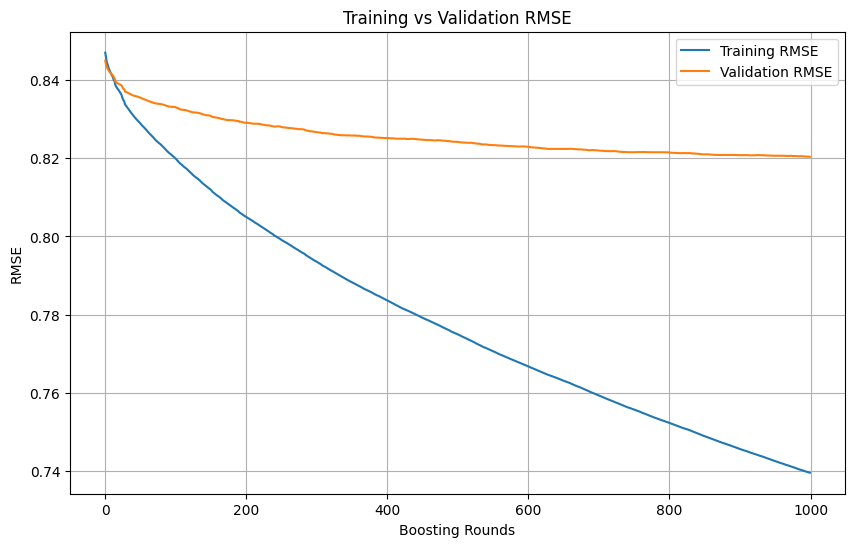

[0]	validation_0-rmse:0.84614	validation_1-rmse:0.84778
[10]	validation_0-rmse:0.84025	validation_1-rmse:0.84370
[20]	validation_0-rmse:0.83674	validation_1-rmse:0.84181
[30]	validation_0-rmse:0.83349	validation_1-rmse:0.84028
[40]	validation_0-rmse:0.83122	validation_1-rmse:0.83945
[50]	validation_0-rmse:0.82867	validation_1-rmse:0.83834
[60]	validation_0-rmse:0.82654	validation_1-rmse:0.83762
[70]	validation_0-rmse:0.82435	validation_1-rmse:0.83681
[80]	validation_0-rmse:0.82256	validation_1-rmse:0.83635
[90]	validation_0-rmse:0.82080	validation_1-rmse:0.83602
[100]	validation_0-rmse:0.81909	validation_1-rmse:0.83546
[110]	validation_0-rmse:0.81726	validation_1-rmse:0.83485
[120]	validation_0-rmse:0.81559	validation_1-rmse:0.83431
[130]	validation_0-rmse:0.81417	validation_1-rmse:0.83388
[140]	validation_0-rmse:0.81277	validation_1-rmse:0.83368
[150]	validation_0-rmse:0.81130	validation_1-rmse:0.83329
[160]	validation_0-rmse:0.80971	validation_1-rmse:0.83285
[170]	validation_0-rmse:0

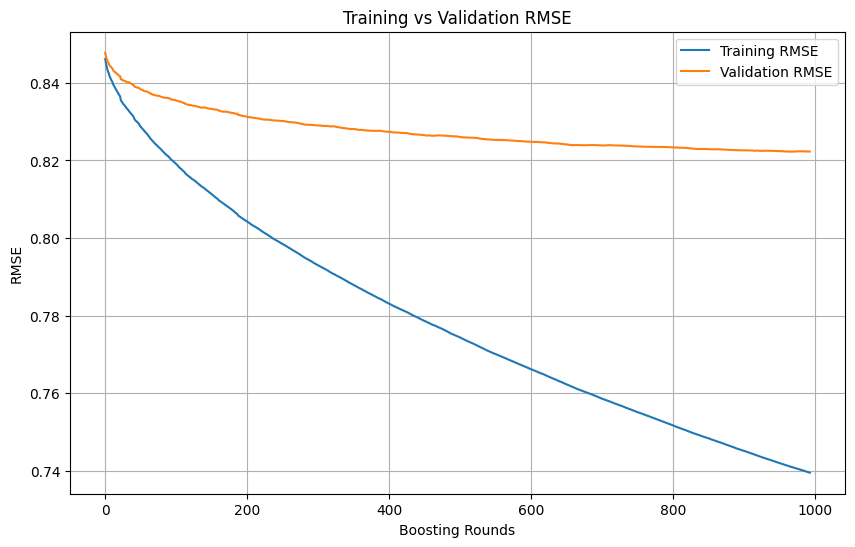

[0]	validation_0-rmse:0.84655	validation_1-rmse:0.84599
[10]	validation_0-rmse:0.84069	validation_1-rmse:0.84216
[20]	validation_0-rmse:0.83747	validation_1-rmse:0.84078
[30]	validation_0-rmse:0.83387	validation_1-rmse:0.83843
[40]	validation_0-rmse:0.83096	validation_1-rmse:0.83704
[50]	validation_0-rmse:0.82889	validation_1-rmse:0.83649
[60]	validation_0-rmse:0.82675	validation_1-rmse:0.83558
[70]	validation_0-rmse:0.82489	validation_1-rmse:0.83513
[80]	validation_0-rmse:0.82313	validation_1-rmse:0.83472
[90]	validation_0-rmse:0.82110	validation_1-rmse:0.83387
[100]	validation_0-rmse:0.81953	validation_1-rmse:0.83357
[110]	validation_0-rmse:0.81793	validation_1-rmse:0.83320
[120]	validation_0-rmse:0.81645	validation_1-rmse:0.83286
[130]	validation_0-rmse:0.81498	validation_1-rmse:0.83267
[140]	validation_0-rmse:0.81368	validation_1-rmse:0.83240
[150]	validation_0-rmse:0.81233	validation_1-rmse:0.83207
[160]	validation_0-rmse:0.81090	validation_1-rmse:0.83170
[170]	validation_0-rmse:0

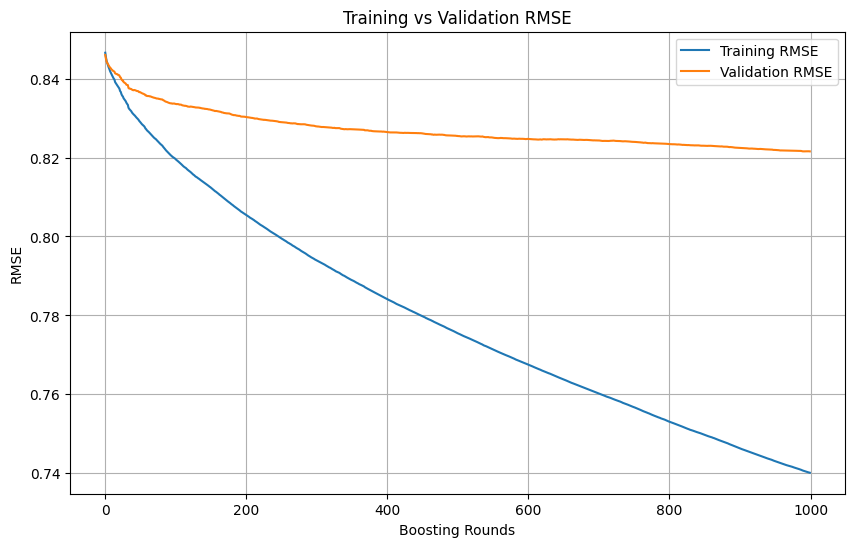

[0]	validation_0-rmse:0.84608	validation_1-rmse:0.84785
[10]	validation_0-rmse:0.83993	validation_1-rmse:0.84403
[20]	validation_0-rmse:0.83642	validation_1-rmse:0.84208
[30]	validation_0-rmse:0.83294	validation_1-rmse:0.84045
[40]	validation_0-rmse:0.83054	validation_1-rmse:0.83961
[50]	validation_0-rmse:0.82852	validation_1-rmse:0.83895
[60]	validation_0-rmse:0.82637	validation_1-rmse:0.83823
[70]	validation_0-rmse:0.82451	validation_1-rmse:0.83750
[80]	validation_0-rmse:0.82265	validation_1-rmse:0.83704
[90]	validation_0-rmse:0.82097	validation_1-rmse:0.83668
[100]	validation_0-rmse:0.81933	validation_1-rmse:0.83632
[110]	validation_0-rmse:0.81759	validation_1-rmse:0.83588
[120]	validation_0-rmse:0.81600	validation_1-rmse:0.83567
[130]	validation_0-rmse:0.81447	validation_1-rmse:0.83535
[140]	validation_0-rmse:0.81282	validation_1-rmse:0.83486
[150]	validation_0-rmse:0.81145	validation_1-rmse:0.83451
[160]	validation_0-rmse:0.80988	validation_1-rmse:0.83403
[170]	validation_0-rmse:0

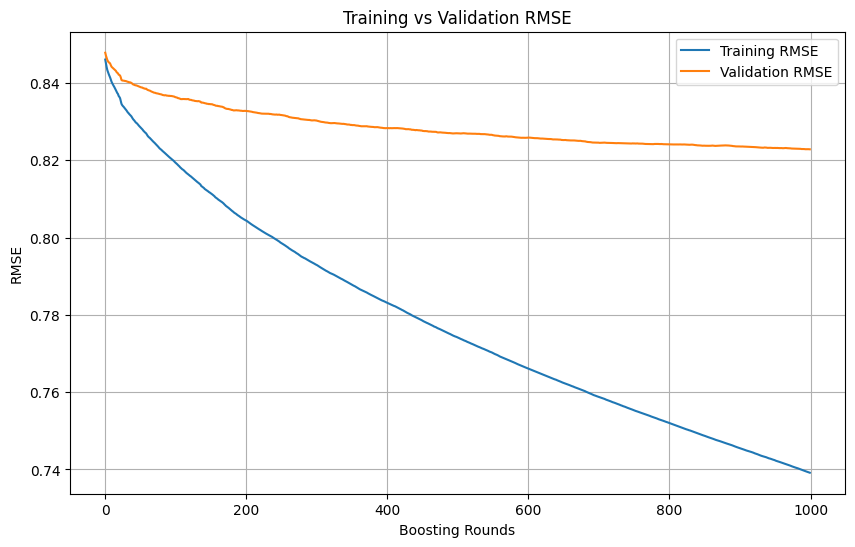

[0]	validation_0-rmse:0.84628	validation_1-rmse:0.84703
[10]	validation_0-rmse:0.84042	validation_1-rmse:0.84342
[20]	validation_0-rmse:0.83647	validation_1-rmse:0.84109
[30]	validation_0-rmse:0.83332	validation_1-rmse:0.83959
[40]	validation_0-rmse:0.83098	validation_1-rmse:0.83881
[50]	validation_0-rmse:0.82864	validation_1-rmse:0.83785
[60]	validation_0-rmse:0.82679	validation_1-rmse:0.83736
[70]	validation_0-rmse:0.82432	validation_1-rmse:0.83641
[80]	validation_0-rmse:0.82242	validation_1-rmse:0.83577
[90]	validation_0-rmse:0.82104	validation_1-rmse:0.83550
[100]	validation_0-rmse:0.81943	validation_1-rmse:0.83500
[110]	validation_0-rmse:0.81780	validation_1-rmse:0.83440
[120]	validation_0-rmse:0.81645	validation_1-rmse:0.83418
[130]	validation_0-rmse:0.81487	validation_1-rmse:0.83370
[140]	validation_0-rmse:0.81347	validation_1-rmse:0.83323
[150]	validation_0-rmse:0.81200	validation_1-rmse:0.83283
[160]	validation_0-rmse:0.81064	validation_1-rmse:0.83264
[170]	validation_0-rmse:0

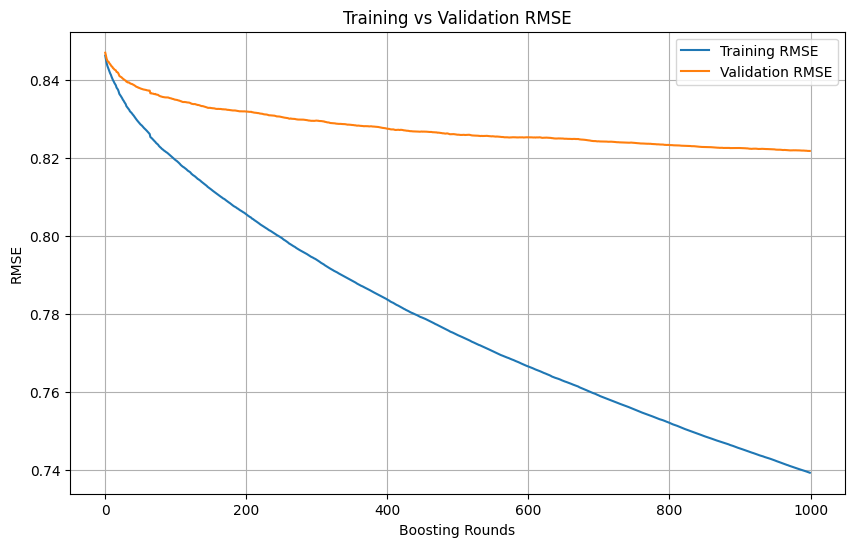

(9425467, 121)
[0]	validation_0-rmse:0.84711	validation_1-rmse:0.84572
[10]	validation_0-rmse:0.84060	validation_1-rmse:0.84130
[20]	validation_0-rmse:0.83758	validation_1-rmse:0.84003
[30]	validation_0-rmse:0.83494	validation_1-rmse:0.83885
[40]	validation_0-rmse:0.83169	validation_1-rmse:0.83708
[50]	validation_0-rmse:0.82944	validation_1-rmse:0.83632
[60]	validation_0-rmse:0.82701	validation_1-rmse:0.83525
[70]	validation_0-rmse:0.82490	validation_1-rmse:0.83445
[80]	validation_0-rmse:0.82310	validation_1-rmse:0.83404
[90]	validation_0-rmse:0.82158	validation_1-rmse:0.83358
[100]	validation_0-rmse:0.81954	validation_1-rmse:0.83287
[110]	validation_0-rmse:0.81789	validation_1-rmse:0.83229
[120]	validation_0-rmse:0.81637	validation_1-rmse:0.83202
[130]	validation_0-rmse:0.81488	validation_1-rmse:0.83169
[140]	validation_0-rmse:0.81340	validation_1-rmse:0.83131
[150]	validation_0-rmse:0.81197	validation_1-rmse:0.83094
[160]	validation_0-rmse:0.81072	validation_1-rmse:0.83085
[170]	vali

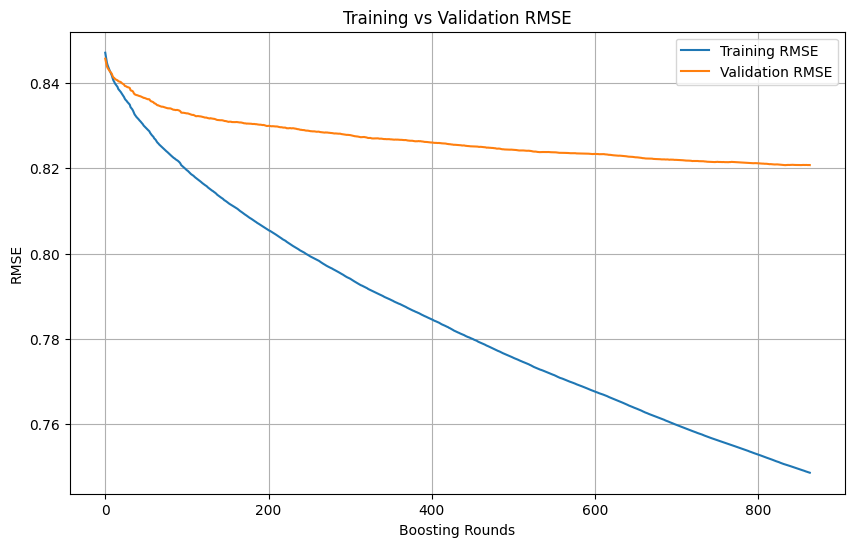

[0]	validation_0-rmse:0.84692	validation_1-rmse:0.84600
[10]	validation_0-rmse:0.84060	validation_1-rmse:0.84146
[20]	validation_0-rmse:0.83731	validation_1-rmse:0.83991
[30]	validation_0-rmse:0.83431	validation_1-rmse:0.83846
[40]	validation_0-rmse:0.83221	validation_1-rmse:0.83773
[50]	validation_0-rmse:0.83006	validation_1-rmse:0.83714
[60]	validation_0-rmse:0.82770	validation_1-rmse:0.83617
[70]	validation_0-rmse:0.82546	validation_1-rmse:0.83518
[80]	validation_0-rmse:0.82359	validation_1-rmse:0.83456
[90]	validation_0-rmse:0.82200	validation_1-rmse:0.83418
[100]	validation_0-rmse:0.82032	validation_1-rmse:0.83364
[110]	validation_0-rmse:0.81872	validation_1-rmse:0.83322
[120]	validation_0-rmse:0.81720	validation_1-rmse:0.83275
[130]	validation_0-rmse:0.81570	validation_1-rmse:0.83256
[140]	validation_0-rmse:0.81436	validation_1-rmse:0.83238
[150]	validation_0-rmse:0.81283	validation_1-rmse:0.83210
[160]	validation_0-rmse:0.81143	validation_1-rmse:0.83168
[170]	validation_0-rmse:0

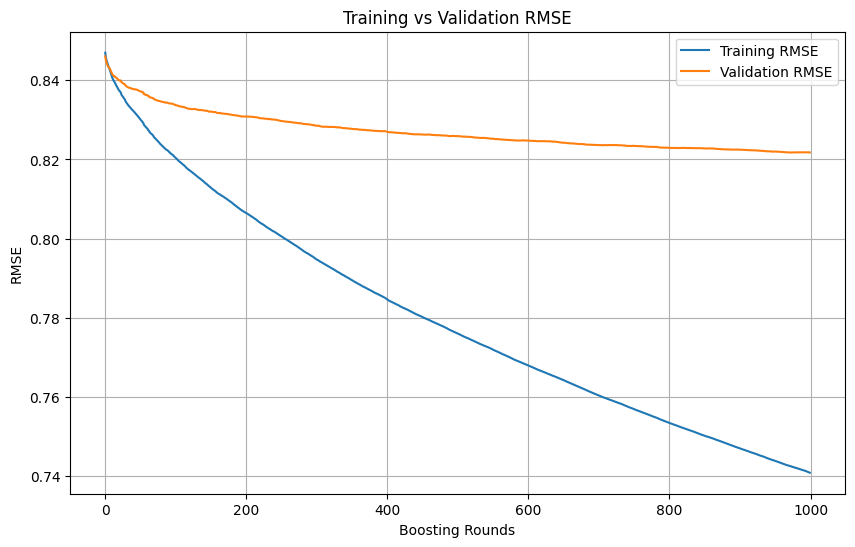

[0]	validation_0-rmse:0.84658	validation_1-rmse:0.84757
[10]	validation_0-rmse:0.84016	validation_1-rmse:0.84313
[20]	validation_0-rmse:0.83661	validation_1-rmse:0.84136
[30]	validation_0-rmse:0.83372	validation_1-rmse:0.84016
[40]	validation_0-rmse:0.83110	validation_1-rmse:0.83893
[50]	validation_0-rmse:0.82931	validation_1-rmse:0.83850
[60]	validation_0-rmse:0.82714	validation_1-rmse:0.83775
[70]	validation_0-rmse:0.82507	validation_1-rmse:0.83703
[80]	validation_0-rmse:0.82298	validation_1-rmse:0.83613
[90]	validation_0-rmse:0.82118	validation_1-rmse:0.83552
[100]	validation_0-rmse:0.81964	validation_1-rmse:0.83515
[110]	validation_0-rmse:0.81789	validation_1-rmse:0.83469
[120]	validation_0-rmse:0.81650	validation_1-rmse:0.83439
[130]	validation_0-rmse:0.81509	validation_1-rmse:0.83413
[140]	validation_0-rmse:0.81360	validation_1-rmse:0.83375
[150]	validation_0-rmse:0.81209	validation_1-rmse:0.83349
[160]	validation_0-rmse:0.81079	validation_1-rmse:0.83335
[170]	validation_0-rmse:0

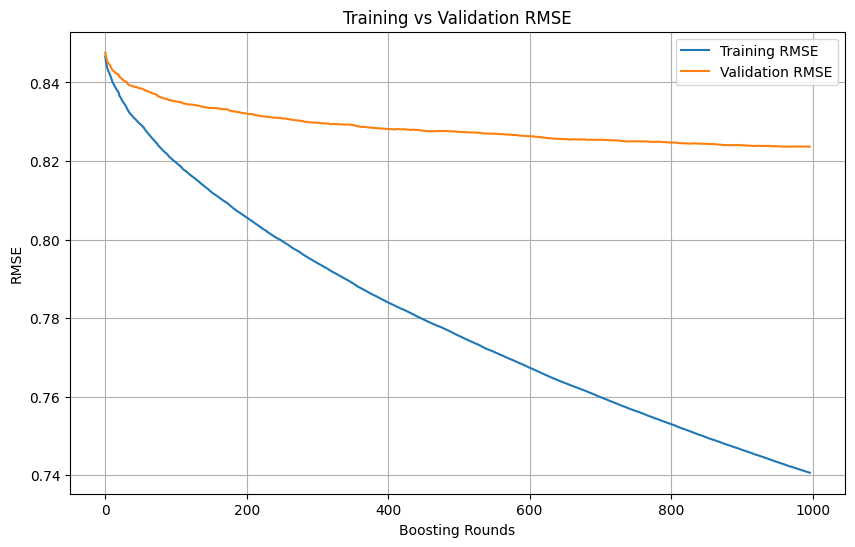

[0]	validation_0-rmse:0.84630	validation_1-rmse:0.84838
[10]	validation_0-rmse:0.84023	validation_1-rmse:0.84430
[20]	validation_0-rmse:0.83609	validation_1-rmse:0.84182
[30]	validation_0-rmse:0.83355	validation_1-rmse:0.84090
[40]	validation_0-rmse:0.83140	validation_1-rmse:0.84014
[50]	validation_0-rmse:0.82905	validation_1-rmse:0.83926
[60]	validation_0-rmse:0.82690	validation_1-rmse:0.83858
[70]	validation_0-rmse:0.82471	validation_1-rmse:0.83776
[80]	validation_0-rmse:0.82266	validation_1-rmse:0.83677
[90]	validation_0-rmse:0.82087	validation_1-rmse:0.83630
[100]	validation_0-rmse:0.81930	validation_1-rmse:0.83600
[110]	validation_0-rmse:0.81783	validation_1-rmse:0.83574
[120]	validation_0-rmse:0.81613	validation_1-rmse:0.83537
[130]	validation_0-rmse:0.81456	validation_1-rmse:0.83494
[140]	validation_0-rmse:0.81312	validation_1-rmse:0.83470
[150]	validation_0-rmse:0.81166	validation_1-rmse:0.83436
[160]	validation_0-rmse:0.81045	validation_1-rmse:0.83423
[170]	validation_0-rmse:0

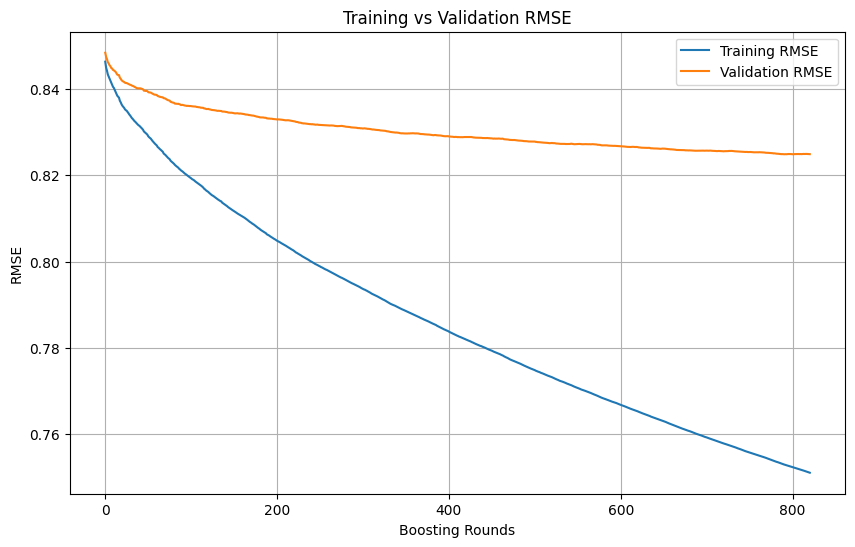

[0]	validation_0-rmse:0.84670	validation_1-rmse:0.84728
[10]	validation_0-rmse:0.84045	validation_1-rmse:0.84290
[20]	validation_0-rmse:0.83734	validation_1-rmse:0.84136
[30]	validation_0-rmse:0.83445	validation_1-rmse:0.84017
[40]	validation_0-rmse:0.83158	validation_1-rmse:0.83883
[50]	validation_0-rmse:0.82933	validation_1-rmse:0.83783
[60]	validation_0-rmse:0.82742	validation_1-rmse:0.83736
[70]	validation_0-rmse:0.82549	validation_1-rmse:0.83690
[80]	validation_0-rmse:0.82355	validation_1-rmse:0.83619
[90]	validation_0-rmse:0.82157	validation_1-rmse:0.83560
[100]	validation_0-rmse:0.81973	validation_1-rmse:0.83508
[110]	validation_0-rmse:0.81813	validation_1-rmse:0.83473
[120]	validation_0-rmse:0.81663	validation_1-rmse:0.83436
[130]	validation_0-rmse:0.81516	validation_1-rmse:0.83390
[140]	validation_0-rmse:0.81364	validation_1-rmse:0.83337
[150]	validation_0-rmse:0.81205	validation_1-rmse:0.83297
[160]	validation_0-rmse:0.81072	validation_1-rmse:0.83254
[170]	validation_0-rmse:0

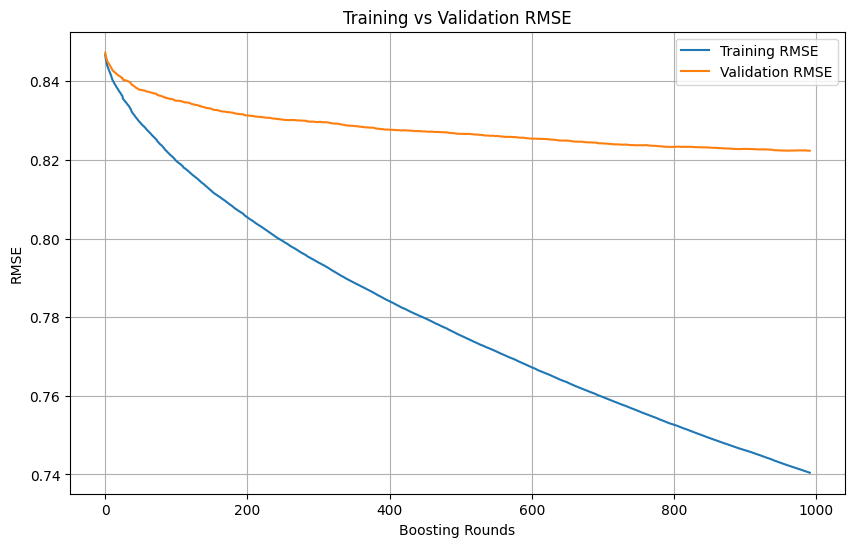

R2 score is: -0.026958585318802353


In [22]:
xgb_train(train_df, y_sr, symbol_id_sr)